In [5]:
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

cudnn.benchmark = True
np.random.seed(0)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [6]:
train = pd.read_csv("MNISTDigits/train.csv", index_col="label")
X, y = train.values, train.index.to_numpy()
del train

X = X.reshape(len(y), 28, 28)

In [7]:
# Define custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform):
        super(ImageDataset, self).__init__()
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0 # (1, 28, 28)
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.input = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.batch1 = nn.BatchNorm2d(64)
        self.conv1 = nn.Conv2d(64, 256, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.batch2 = nn.BatchNorm2d(256)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(50176, 128)
        self.drop1 = nn.Dropout(p=0.4)
        self.out = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.mish(self.input(x))
        x = self.batch1(x)
        x = F.mish(self.conv1(x))
        x = self.batch2(self.pool1(x))
        x = self.flatten(x)
        x = F.mish(self.fc1(x))
        x = self.drop1(x)
        x = self.out(x)
        
        return x

In [35]:
transform_pipeline = v2.Compose([
    v2.RandomHorizontalFlip(p=0.3), # Horizontally flip with 30% probability
    v2.RandomVerticalFlip(p=0.3), # Vertical flip with 30% probability
    v2.GaussianBlur(kernel_size=3), # Blur the images using a Gaussian kernel
    v2.RandomRotation(degrees=(-45, 45)), # Randomly rotate the images 
    v2.ToDtype(torch.float32, scale=True), # Upated version of ToTensor
    v2.Normalize(mean=[0.485], std=[0.229]), # Only 1 channel in the image
])

In [36]:
dataset = ImageDataset(X, y, transform_pipeline)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [37]:
model = ConvNet().to(device)

In [38]:
LEARNING_RATE = 0.01
EPOCHS = 15

optimizer = optim.NAdam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

losses = []
model.train()
for epoch in tqdm(range(EPOCHS), total=EPOCHS):
    running_loss = 0.0
    for images, labels in data_loader:
        inputs, targets = images.float().to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    scheduler.step()
    epoch_loss = running_loss / len(data_loader)
    losses.append(epoch_loss)
    print(f"[{epoch+1}] Loss: {epoch_loss}")

print("Finished training")

  7%|▋         | 1/15 [00:35<08:17, 35.54s/it]

[1] Loss: 2.048484755614758


 13%|█▎        | 2/15 [01:10<07:40, 35.45s/it]

[2] Loss: 1.4873429363539592


 20%|██        | 3/15 [01:46<07:04, 35.41s/it]

[3] Loss: 1.398556140459836


 27%|██▋       | 4/15 [02:21<06:30, 35.53s/it]

[4] Loss: 1.1682936917519824


 33%|███▎      | 5/15 [02:57<05:54, 35.45s/it]

[5] Loss: 0.7740536746731995


 40%|████      | 6/15 [03:32<05:18, 35.41s/it]

[6] Loss: 0.5247933986841997


 47%|████▋     | 7/15 [04:08<04:43, 35.43s/it]

[7] Loss: 0.43503649389907106


 53%|█████▎    | 8/15 [04:43<04:08, 35.44s/it]

[8] Loss: 0.3202248223953777


 60%|██████    | 9/15 [05:19<03:32, 35.45s/it]

[9] Loss: 0.18035595569209603


 67%|██████▋   | 10/15 [05:54<02:57, 35.45s/it]

[10] Loss: 0.13821544906456176


 73%|███████▎  | 11/15 [06:29<02:21, 35.45s/it]

[11] Loss: 0.11036258189452747


 80%|████████  | 12/15 [07:05<01:46, 35.46s/it]

[12] Loss: 0.10135756295402584


 87%|████████▋ | 13/15 [07:40<01:10, 35.44s/it]

[13] Loss: 0.09226985373413771


 93%|█████████▎| 14/15 [08:16<00:35, 35.53s/it]

[14] Loss: 0.08567200540713796


100%|██████████| 15/15 [08:52<00:00, 35.50s/it]

[15] Loss: 0.0867216184726793
Finished training


In [39]:
def predict(m, dl, device):
    m.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():  # Disable gradient computation for inference
        for images, labels in dl:
            images = images.to(device)
            outputs = m(images)
            _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels

In [40]:
predictions, true_labels = predict(model, data_loader, device)

In [41]:
accuracy_score(true_labels, predictions) 

0.9957380952380952

In [42]:
torch.save(model.state_dict(), "models/mnist_digit_cnn.pt")

# Results
1. 99.73% on the train data using AdamW and no transforms
2. 99.57% on the train data using NAdam and transforms

In [49]:
def predict_batch(m, batch, device):
    m.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():  # Disable gradient computation for inference
        images, labels = batch[0], batch[1]
        images = images.to(device)
        outputs = m(images)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels

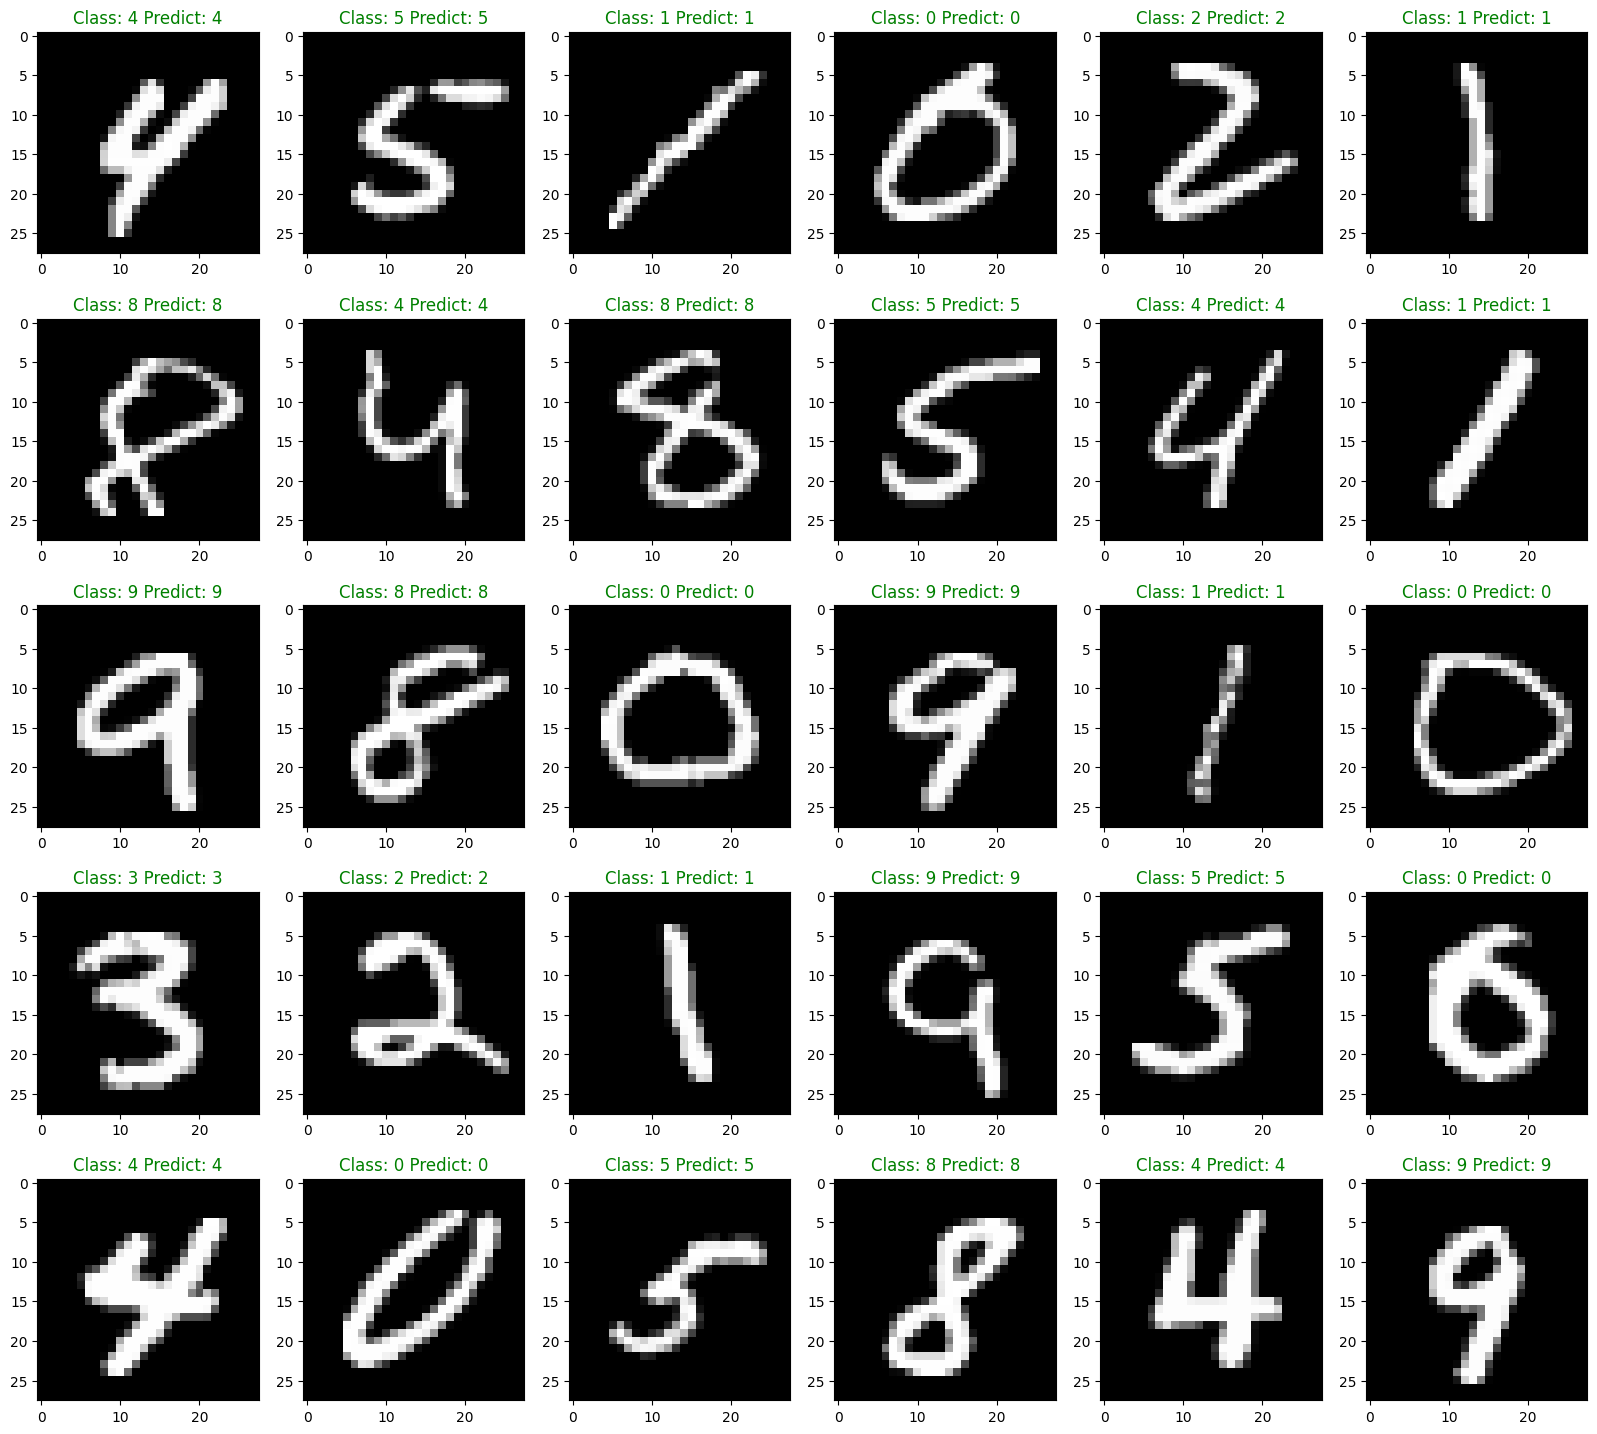

In [58]:
batch = next(iter(data_loader))
images, labels = batch[0], batch[1]
predictions = predict_batch(model, batch, device)[0]

fig, ax = plt.subplots(5, 6, figsize=(20, 18))
ax = ax.flatten()
for i in range(30):
    ax[i].imshow(images[i].squeeze(), cmap="gray")
    c = "red"
    if labels[i].item() == predictions[i]:
        c = "green"
    ax[i].set_title(f"Class: {labels[i].item()} Predict: {predictions[i]}", color=c)

plt.show()